In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 199 kB 44.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=8455832145778981e566f173ce4a27331bbcbd286748b9ffdb752f372c769f3a
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
s_data = spark.read.option("header", True).csv('SampleSuperstore.csv')
s_data.show()

+--------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+------------+--------+--------+--------+--------+
|     Ship Mode|    Segment|      Country|           City|         State|Postal Code| Region|       Category|Sub-Category|   Sales|Quantity|Discount|  Profit|
+--------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+------------+--------+--------+--------+--------+
|  Second Class|   Consumer|United States|      Henderson|      Kentucky|      42420|  South|      Furniture|   Bookcases|  261.96|       2|       0| 41.9136|
|  Second Class|   Consumer|United States|      Henderson|      Kentucky|      42420|  South|      Furniture|      Chairs|  731.94|       3|       0| 219.582|
|  Second Class|  Corporate|United States|    Los Angeles|    California|      90036|   West|Office Supplies|      Labels|   14.62|       2|       0|  6.8714|
|Standard Class|   Consumer|United States|Fort

EDA

In [ ]:
#view data information
s_data.describe().show()
#data has no nulls or na and datatypes seem fine

+-------+--------------+-----------+-------------+--------+-------+------------------+-------+----------+------------+-----------------+-----------------+-------------------+------------------+
|summary|     Ship Mode|    Segment|      Country|    City|  State|       Postal Code| Region|  Category|Sub-Category|            Sales|         Quantity|           Discount|            Profit|
+-------+--------------+-----------+-------------+--------+-------+------------------+-------+----------+------------+-----------------+-----------------+-------------------+------------------+
|  count|          9994|       9994|         9994|    9994|   9994|              9994|   9994|      9994|        9994|             9994|             9994|               9994|              9994|
|   mean|          null|       null|         null|    null|   null|  55190.3794276566|   null|      null|        null|229.8580008304938|3.789573744246548|0.15620272163298934|28.656896307784802|
| stddev|          null|      

In [ ]:
#s_data.corr()

,Postal Code,Sales,Quantity,Discount,Profit
Postal Code,1.000000,-0.023854,0.012761,0.058443,-0.029961
Sales,-0.023854,1.000000,0.200795,-0.028190,0.479064
Quantity,0.012761,0.200795,1.000000,0.008623,0.066253
Discount,0.058443,-0.028190,0.008623,1.000000,-0.219487
Profit,-0.029961,0.479064,0.066253,-0.219487,1.000000


In [ ]:
s_data.select('Country').distinct().collect()

[Row(Country='United States')]

In [ ]:
s_data.select('Segment').distinct().collect()

[Row(Segment='Consumer'), Row(Segment='Home Office'), Row(Segment='Corporate')]

In [ ]:
#as there is no change in this col and it doesn't add any further info, so we drop it
s_data = s_data.drop('Country')

In [ ]:
s_data.show()

+--------------+-----------+---------------+--------------+-----------+-------+---------------+------------+--------+--------+--------+--------+
|     Ship Mode|    Segment|           City|         State|Postal Code| Region|       Category|Sub-Category|   Sales|Quantity|Discount|  Profit|
+--------------+-----------+---------------+--------------+-----------+-------+---------------+------------+--------+--------+--------+--------+
|  Second Class|   Consumer|      Henderson|      Kentucky|      42420|  South|      Furniture|   Bookcases|  261.96|       2|       0| 41.9136|
|  Second Class|   Consumer|      Henderson|      Kentucky|      42420|  South|      Furniture|      Chairs|  731.94|       3|       0| 219.582|
|  Second Class|  Corporate|    Los Angeles|    California|      90036|   West|Office Supplies|      Labels|   14.62|       2|       0|  6.8714|
|Standard Class|   Consumer|Fort Lauderdale|       Florida|      33311|  South|      Furniture|      Tables|957.5775|       5|    

In [ ]:
s_data =s_data.withColumnRenamed('Sub-Category', 'SubCategory')

In [ ]:
s_data.show()

+--------------+-----------+---------------+--------------+-----------+-------+---------------+-----------+--------+--------+--------+--------+
|     Ship Mode|    Segment|           City|         State|Postal Code| Region|       Category|SubCategory|   Sales|Quantity|Discount|  Profit|
+--------------+-----------+---------------+--------------+-----------+-------+---------------+-----------+--------+--------+--------+--------+
|  Second Class|   Consumer|      Henderson|      Kentucky|      42420|  South|      Furniture|  Bookcases|  261.96|       2|       0| 41.9136|
|  Second Class|   Consumer|      Henderson|      Kentucky|      42420|  South|      Furniture|     Chairs|  731.94|       3|       0| 219.582|
|  Second Class|  Corporate|    Los Angeles|    California|      90036|   West|Office Supplies|     Labels|   14.62|       2|       0|  6.8714|
|Standard Class|   Consumer|Fort Lauderdale|       Florida|      33311|  South|      Furniture|     Tables|957.5775|       5|    0.45|-3

In [ ]:
s_data.createOrReplaceTempView("Superstore")

Finding areas of weak profit

In [ ]:
result = spark.sql("select City, State,	Region, Profit from Superstore where Profit < 0 ")
result.show()

+---------------+------------+-------+----------+
|           City|       State| Region|    Profit|
+---------------+------------+-------+----------+
|Fort Lauderdale|     Florida|  South|  -383.031|
|     Fort Worth|       Texas|Central|  -123.858|
|     Fort Worth|       Texas|Central|    -3.816|
|   Philadelphia|Pennsylvania|   East|   -1.0196|
|   Philadelphia|Pennsylvania|   East|-1665.0522|
|   Philadelphia|Pennsylvania|   East|   -7.0532|
|   Philadelphia|Pennsylvania|   East|    -5.715|
|     Richardson|       Texas|Central|  -147.963|
|        Houston|       Texas|Central|  -46.9764|
|        Houston|       Texas|Central|   -15.147|
|        Chicago|    Illinois|Central|  -15.2225|
|        Memphis|   Tennessee|  South| -114.3912|
|        Memphis|   Tennessee|  South|   -18.196|
|        Houston|       Texas|Central|   -1.9344|
|        Houston|       Texas|Central|   -5.8248|
|        Houston|       Texas|Central|   -14.475|
|        Chicago|    Illinois|Central|  -48.9549|


Which Category makes the highest sales?

In [ ]:
result = spark.sql("select sum(Sales) as totalSales, Category from Superstore group by Category order by totalSales desc ")
result.show()

+-----------------+---------------+
|       totalSales|       Category|
+-----------------+---------------+
|836154.0329999966|     Technology|
|741999.7952999998|      Furniture|
|719047.0320000029|Office Supplies|
+-----------------+---------------+



Visualization

In [ ]:
Categ_Sales = result.toPandas()

In [ ]:
Categ_Sales

,totalSales,Category
0,836154.0330,Technology
1,741999.7953,Furniture
2,719047.0320,Office Supplies


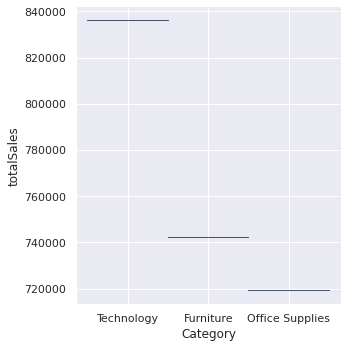

In [ ]:
sns.displot(Categ_Sales, x="Category",y='totalSales',binwidth=10)


Pie Chart shows each Category portion from market

([<matplotlib.patches.Wedge at 0x7faa72aab150>,
 [Text(0.45585027961816843, 1.00109965666363, 'Technology'),
  Text(-1.0859233062515894, -0.17541542959391293, 'Furniture'),
  Text(0.609660527768593, -0.9155949109081596, 'Office Supplies')],
 [Text(0.2486456070644555, 0.5460543581801618, '36%'),
  Text(-0.5923218034099578, -0.0956811434148616, '32%'),
  Text(0.3325421060555962, -0.4994154059499052, '31%')])

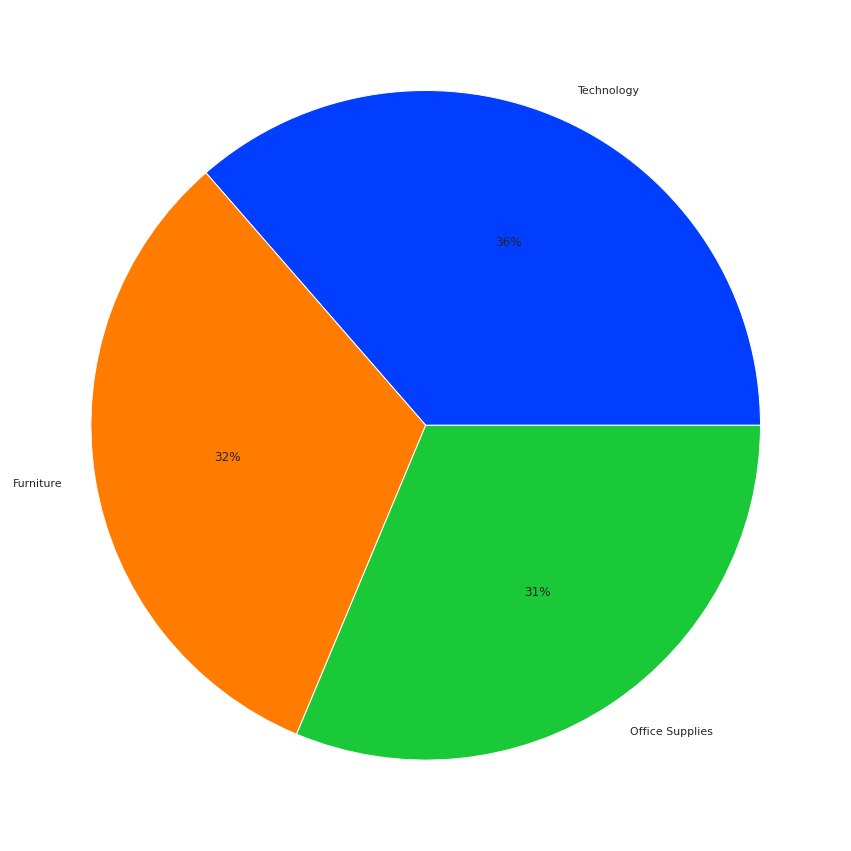

In [ ]:
palette_color = sns.color_palette('bright')
plt.pie(Categ_Sales['totalSales'], labels=Categ_Sales['Category'], colors=palette_color, autopct='%.0f%%')

Technology makes highest sales

5 top states that make orders?




In [ ]:
result = spark.sql("select count(State) as numOccurance, State from Superstore group by State order by numOccurance desc limit 5")
result.show()

+------------+------------+
|numOccurance|       State|
+------------+------------+
|        2001|  California|
|        1128|    New York|
|         985|       Texas|
|         587|Pennsylvania|
|         506|  Washington|
+------------+------------+



visualization

In [ ]:
State_Order = result.toPandas()

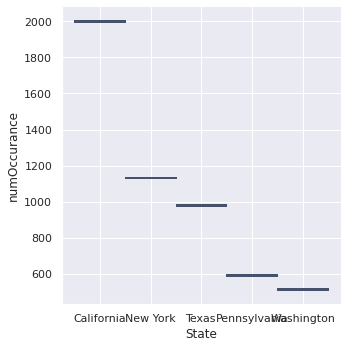

In [ ]:
#sns.set(rc = {'figure.figsize':(15,30)})
sns.displot(State_Order, x="State",y='numOccurance',binwidth=10)


Quantity sold of each subcategory

In [ ]:
result = spark.sql("select sum(Quantity) as q, SubCategory from Superstore group by SubCategory order by q desc ")
result.show()

+------+-----------+
|     q|SubCategory|
+------+-----------+
|5974.0|    Binders|
|5178.0|      Paper|
|3563.0|Furnishings|
|3289.0|     Phones|
|3158.0|    Storage|
|3000.0|        Art|
|2976.0|Accessories|
|2356.0|     Chairs|
|1729.0| Appliances|
|1400.0|     Labels|
|1241.0|     Tables|
| 914.0|  Fasteners|
| 906.0|  Envelopes|
| 868.0|  Bookcases|
| 647.0|   Supplies|
| 440.0|   Machines|
| 234.0|    Copiers|
+------+-----------+



In [ ]:
Subq_totalsq = result.toPandas()

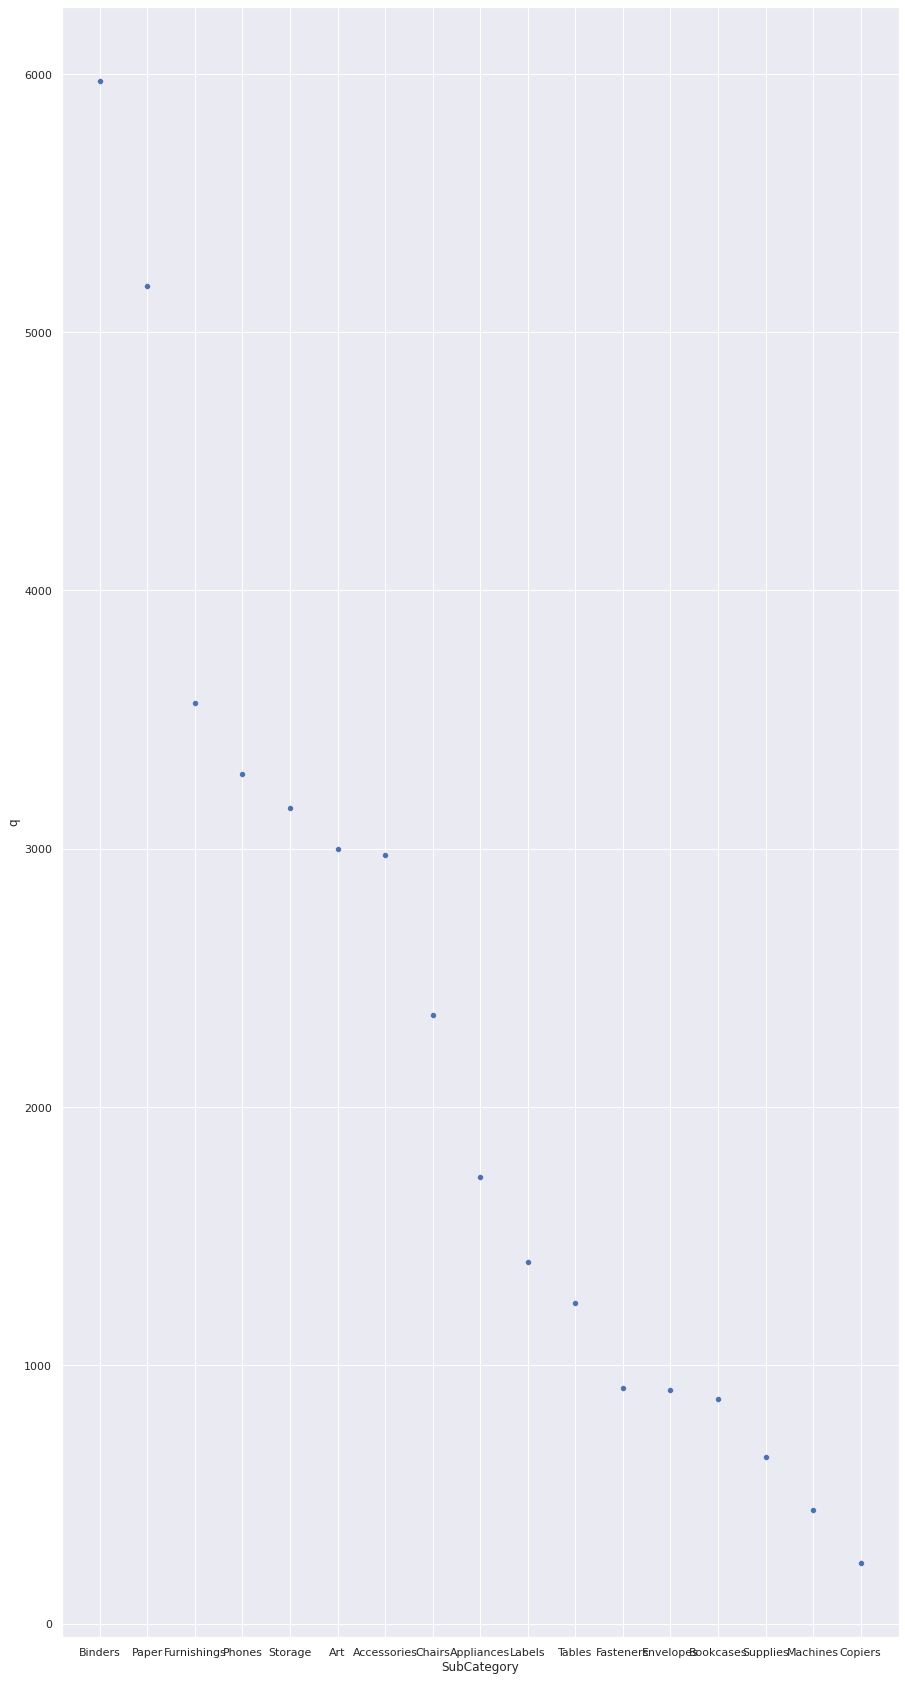

In [ ]:
sns.scatterplot(x="SubCategory",y='q',data = Subq_totalsq)